In [3]:
## Basic exploration

### Import modules

In [4]:
import os, sys, time, random, math
import tarfile, zipfile  # Work with compressed files

import numpy as np     # Linear algebra
import pandas as pd    # Data processing

from IPython.display import display, Image

from subprocess import check_output
print(check_output(["ls", "../../input"]).decode("utf8"))

test.csv
train.csv



### Load data

In [5]:
data = pd.read_csv("../../input/train.csv")
test_data = pd.read_csv("../../input/test.csv")

### Examine shape of datasets

In [6]:
print ("Dataset has {} samples with {} features each.".format(*data.shape))
data.info()
display(data.head(5))

print ("Dataset has {} samples with {} features each.".format(*test_data.shape))
test_data.info()
display(test_data.head(5))

Dataset has 188318 samples with 132 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


Dataset has 125546 samples with 131 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


### Examine distrbutions of datasets

In [7]:
cols = data.columns
cats = [c for c in cols if "cat" in c]
conts = [c for c in cols if "cont" in c]

print('Total {} columns. {} category columns, {} continuous columns'.format(len(cols), len(cats), len(conts)))
print('Avg loss = {:.3f}'.format(data['loss'].mean()))
for c in conts:
    print('Average value of {} = {:.3f}'.format(c, data[c].mean()) )
data['loss'].describe()

Total 132 columns. 116 category columns, 14 continuous columns
Avg loss = 3037.338
Average value of cont1 = 0.494
Average value of cont2 = 0.507
Average value of cont3 = 0.499
Average value of cont4 = 0.492
Average value of cont5 = 0.487
Average value of cont6 = 0.491
Average value of cont7 = 0.485
Average value of cont8 = 0.486
Average value of cont9 = 0.486
Average value of cont10 = 0.498
Average value of cont11 = 0.494
Average value of cont12 = 0.493
Average value of cont13 = 0.493
Average value of cont14 = 0.496


count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

### Plot loss distributions

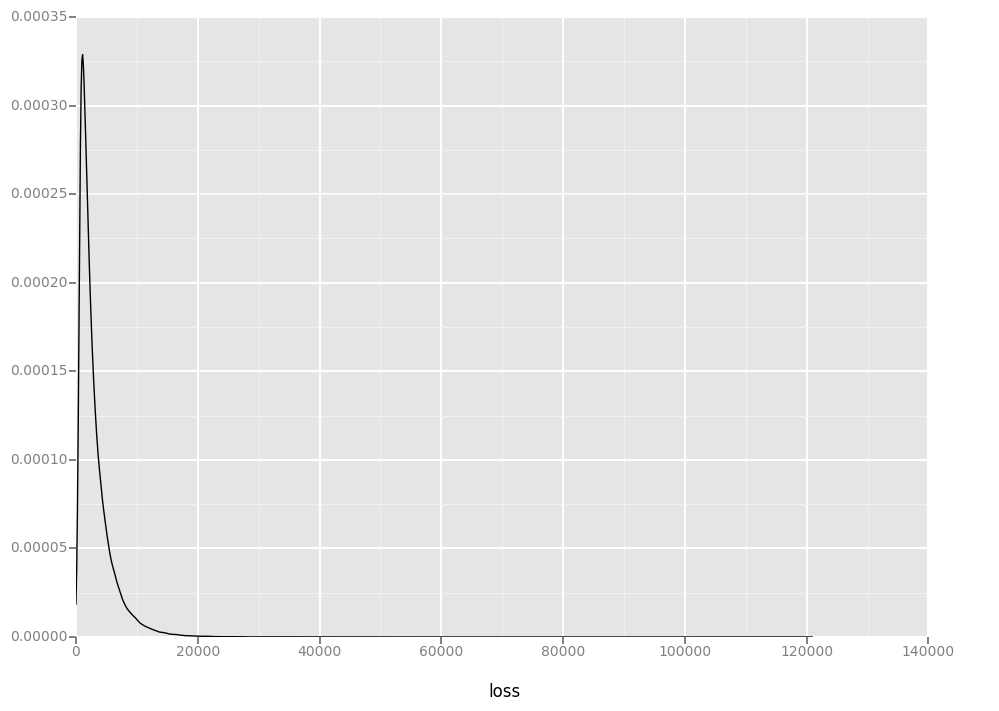

<ggplot: (8755081591332)>

In [8]:
from ggplot import *
ggplot(aes(x = 'loss'), data) + geom_density()

### Check if category values of test_data appear in train_data

In [20]:
for c in cats[0:]:
    vals_d = data[c].unique()
    vals_t = test_data[c].unique()
    for v in vals_t:
        if v not in vals_d:
            print(c, v)

cat89 F
cat92 G
cat92 E
cat96 H
cat99 U
cat103 M
cat106 Q
cat109 AD
cat110 BH
cat110 CA
cat110 EN
cat111 L
cat113 AA
cat113 R
cat116 AQ
cat116 EM
cat116 FY
cat116 AI
cat116 N
cat116 ET
cat116 KO
cat116 BJ
cat116 IW
cat116 DB
cat116 LP
cat116 MX
cat116 BR
cat116 BH
cat116 JS
cat116 ER
cat116 A
cat116 BN
cat116 BE
cat116 IS
cat116 LS
cat116 HS
cat116 EX
